# Classification. Linear models and KNN

In [28]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,OrdinalEncoder 

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [30]:
PATH = "./data/"

In [31]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [32]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

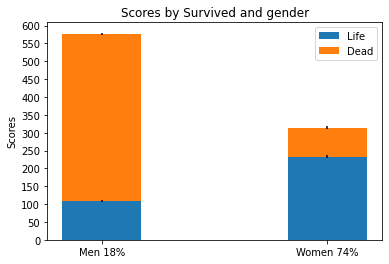

In [33]:
enc = OrdinalEncoder()
enc.fit(data[["Sex"]])
data[["Sex"]] = enc.transform(data[["Sex"]])
data
LM = data[( data["Sex"]== 1.0) & (data["Survived"]== 1 )]['Sex'].count()
DM = data[( data["Sex"]== 1.0) & (data["Survived"]== 0 )]['Sex'].count()
LF = data[( data["Sex"]== 0.0) & (data["Survived"]== 1 )]['Sex'].count()
DF = data[( data["Sex"]== 0.0) & (data["Survived"]== 0 )]['Sex'].count()


N = 2
menMeans = (LM, LF)
womenMeans = (DM, DF)
menStd = (3, 5)
womenStd = (3, 5)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by Survived and gender')
plt.xticks(ind, ('Men {}%'.format((LM/(LM+DM)*100).astype(int)),
                 'Women {}%'.format((LF/(LF+DF)*100).astype(int)),))
plt.yticks(np.arange(0, 650, 50))
plt.legend((p1[0], p2[0]), ('Life', 'Dead'))


plt.show()

## For ethical reasons, women had priority of salvation 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

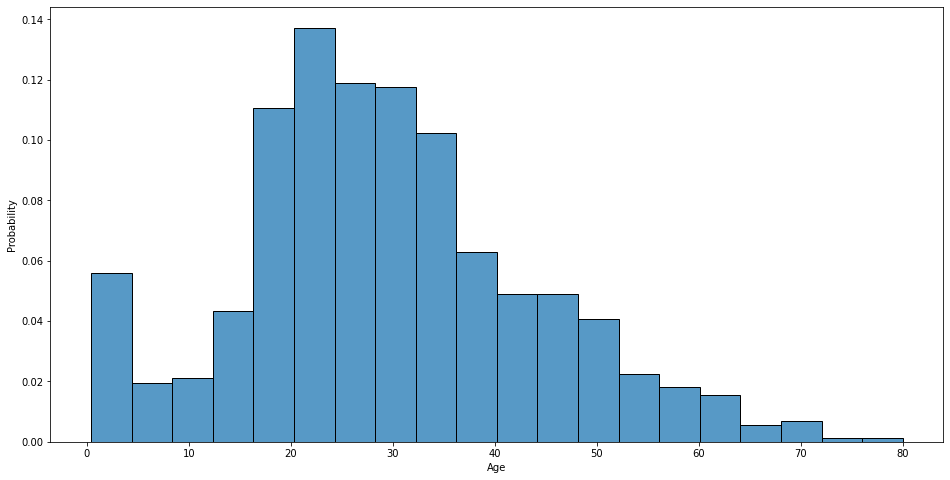

In [34]:
plt.figure(figsize=(16,8))
sns.histplot(data['Age'], stat='probability')
plt.show()

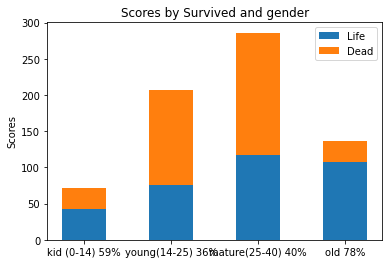

In [35]:
data['age_group'] = data.apply(lambda x: "kid" if x['Age'] < 14 
                               else 'young' if x['Age'] < 25
                               else 'mature' if x['Age'] <= 40
                               else 'old', axis=1)
LK = data[( data['age_group']==  "kid" ) & (data["Survived"]== 1 )]['Sex'].count()
DK = data[( data['age_group']==  "kid" ) & (data["Survived"]== 0 )]['Sex'].count()
LY = data[( data['age_group']==  "young" ) & (data["Survived"]== 1 )]['Sex'].count()
DY = data[( data['age_group']==  "young" ) & (data["Survived"]== 0 )]['Sex'].count()
LM = data[( data['age_group']==  "mature" ) & (data["Survived"]== 1 )]['Sex'].count()
DM = data[( data['age_group']==  "mature" ) & (data["Survived"]== 0 )]['Sex'].count()
LO = data[( data['age_group']==  "old" ) & (data["Survived"]== 1 )]['Sex'].count()
DO = data[( data['age_group']==  "kid" ) & (data["Survived"]== 0 )]['Sex'].count()

N = 4
life = (LK, LY ,LM , LO)
dead = (DK, DY ,DM , DO)
ltd = (5, 5 ,5 ,5 )
dtd = (5, 5, 5, 5 )
ind = np.arange(N)    # the x locations for the groups
width = 0.5      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, life, width,)
p2 = plt.bar(ind, dead, width,
             bottom=life, )

plt.ylabel('Scores')
plt.title('Scores by Survived and gender')
plt.xticks(ind, ('kid (0-14) {}%'.format((LK/(LK+DK)*100).astype(int)),
                 'young(14-25) {}%'.format((LY/(LY+DY)*100).astype(int)),
                 'mature(25-40) {}%'.format((LM/(LM+DM)*100).astype(int)) , 
                 'old {}%'.format((LO/(LO+DO)*100).astype(int))))
plt.yticks(np.arange(0, 350, 50))
plt.legend((p1[0], p2[0]), ('Life', 'Dead'))


plt.show()





## For ethical reasons, old people and children had a priority of salvation. but the percentage of children who die is high due to the fact that not everyone could survive the cold 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

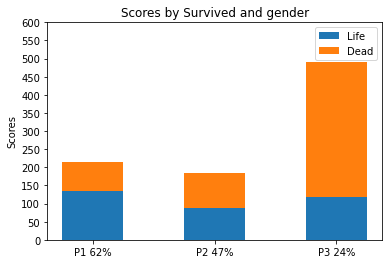

In [36]:
P1D = data[( data["Pclass"]== 1) & (data["Survived"]== 0 )]['Sex'].count()
P1L = data[( data["Pclass"]== 1) & (data["Survived"]== 1 )]['Sex'].count()
P2D = data[( data["Pclass"]== 2) & (data["Survived"]== 0 )]['Sex'].count()
P2L = data[( data["Pclass"]== 2) & (data["Survived"]== 1 )]['Sex'].count()
P3D = data[( data["Pclass"]== 3) & (data["Survived"]== 0 )]['Sex'].count()
P3L = data[( data["Pclass"]== 3) & (data["Survived"]== 1 )]['Sex'].count()

N = 3
P1 = (P1L, P2L ,P3L )
P2 = (P1D, P2D ,P3D )

ind = np.arange(N)   

ltd = (5, 5 ,5 )
dtd = (5, 5, 5 )
ind = np.arange(N)    # the x locations for the groups
width = 0.5      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, P1, width,)
p2 = plt.bar(ind, P2, width,
             bottom=P1 )

plt.ylabel('Scores')
plt.title('Scores by Survived and gender')
plt.xticks(ind, ('P1 {}%'.format((P1L/(P1D+P1L)*100).astype(int)), 'P2 {}%'.format((P2L/(P2D+P2L)*100).astype(int))
                 ,'P3 {}%'.format((P3L/(P3D+P3L)*100).astype(int)) ))
plt.yticks(np.arange(0, 650, 50))
plt.legend((p1[0], p2[0]), ('Life', 'Dead'))


plt.show()



## People for the First Class had more places in the boats, because of this, more of them were saved.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [37]:
data.isnull().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age          177
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin        687
Embarked       2
age_group      0
dtype: int64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

## I will fill in the missing age values with the median value and the booth values are not so important for predictions 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [38]:
y = data['Survived']

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
data['Age'] = data['Age'].fillna(data['Age'].median())
features = ['Pclass' , 'Sex' ,'Age' ,'SibSp' ,'Parch'  ,'Fare']
for feat in features:
    tit_train, tit_val, tit_surv_train, tit_surv_val = train_test_split(data[features], data['Survived'], 
                                                                             train_size=0.8, random_state=2 ) 
Lr = LogisticRegression(solver='liblinear', penalty='l1' )
clf = Lr.fit(tit_train, tit_surv_train)
print ( ' Logistic Regression score {}'.format (Lr.score(tit_val,tit_surv_val) ) )
knn = KNeighborsClassifier(n_neighbors = 2, weights='uniform', algorithm='auto')
knnclf = knn.fit(tit_train, tit_surv_train)
print ( ' KNeighborsClassifier score {}'.format (knnclf.score(tit_val,tit_surv_val) ) )

 Logistic Regression score 0.7597765363128491
 KNeighborsClassifier score 0.6480446927374302


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [40]:
data.isnull().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin        687
Embarked       2
age_group      0
dtype: int64

In [41]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
data_train = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
def make_features(data_train):
    data_train['Ticket_type'] = data_train['Ticket'].apply(lambda x: x[0:3])
    data_train['Ticket_type'] = data_train['Ticket_type'].astype('category')
    data_train['Ticket_type'] = data_train['Ticket_type'].cat.codes
    
    data_train['Words_Count'] = data_train['Name'].apply(lambda x: len(x.split()))
    data_train['Has_Cabin'] = data_train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    
    data_train['Title'] = data_train['Name'].apply(get_title)
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data_train['Title'] = data_train['Title'].map(title_mapping)
    data_train['Title'] = data_train['Title'].fillna(0)
    
    # Mapping Embarked
    data_train["Embarked"].fillna("S",inplace=True)
    data_train['Embarked'] = data_train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    data_train['Fare'] = data_train['Fare'].fillna(data_train['Fare'].median())
    data_train.loc[ data_train['Fare'] <= 7.91, 'Fare']       = 0
    data_train.loc[(data_train['Fare'] > 7.91) & (data_train['Fare'] <= 14.454), 'Fare'] = 1
    data_train.loc[(data_train['Fare'] > 14.454) & (data_train['Fare'] <= 31), 'Fare']   = 2
    data_train.loc[ data_train['Fare'] > 31, 'Fare']      = 3
    data_train['Fare'] = data_train['Fare'].astype(int)
    
    # Mapping Age
    data_train.loc[ data_train['Age'] <= 16, 'Age'] = 0
    data_train.loc[(data_train['Age'] > 16) & (data_train['Age'] <= 32), 'Age'] = 1
    data_train.loc[(data_train['Age'] > 32) & (data_train['Age'] <= 48), 'Age'] = 2
    data_train.loc[(data_train['Age'] > 48) & (data_train['Age'] <= 64), 'Age'] = 3
    data_train.loc[ data_train['Age'] > 64, 'Age'] = 4 ;

    
    enc = OrdinalEncoder()
    enc.fit(data_train[["Sex"]])
    
    data_train[["Sex"]] = enc.transform(data_train[["Sex"]])
    
    data_train['Family_Size']=data_train['SibSp']+data_train['Parch'] + 1 
    data_train['Age'] = data_train['Age'].fillna(data_train['Age'].median())
    data_train['Age*Class']=data_train['Age']*data_train['Pclass']
    data_train['Fare_Per_Person']=data_train['Fare']/(data_train['Family_Size'])
    features = ['Pclass' , 'Sex' ,'Age*Class' ,'Family_Size'  ,'Fare_Per_Person' ,'Embarked']
    new_data = data_train
    return new_data
data_train = make_features(data_train)
data_test = make_features(data_test)
data_train = data_train.drop(['Name','Ticket', 'Cabin'], axis=1)

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

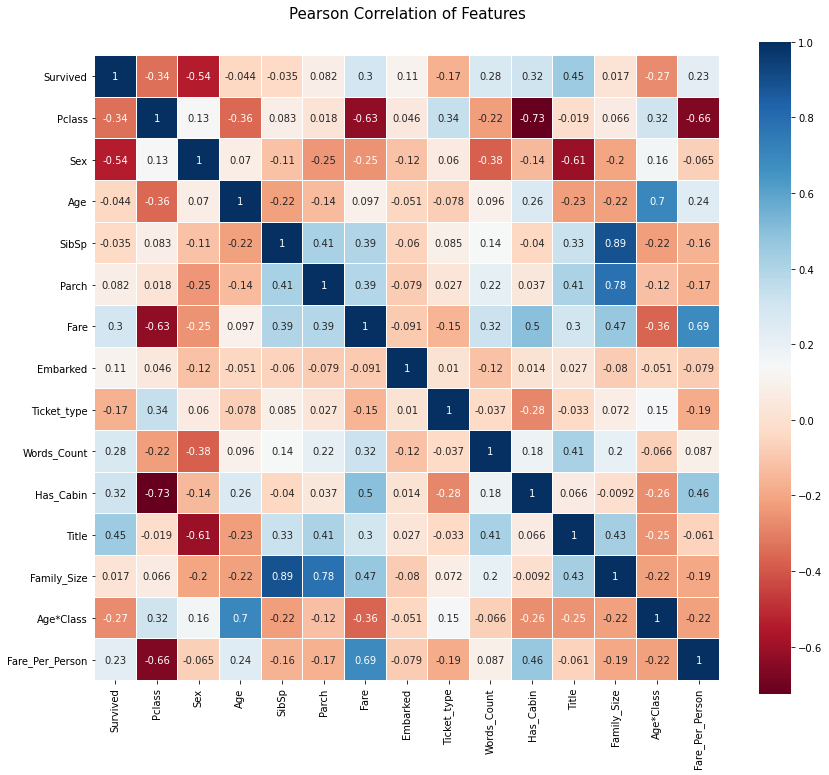

In [42]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [43]:
data_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_type,Words_Count,Has_Cabin,Title,Family_Size,Age*Class,Fare_Per_Person
PassengerId,,,,,,,,,,,,,,,
1,0,3,1.0,1.0,1,0,0,0,124,4,0,1.0,2,3.0,0.0
2,1,1,0.0,2.0,1,0,3,1,137,7,1,3.0,2,2.0,1.5
3,1,3,0.0,1.0,0,0,1,0,148,3,0,2.0,1,3.0,1.0
4,1,1,0.0,2.0,1,0,3,0,3,7,1,3.0,2,2.0,1.5
5,0,3,1.0,2.0,0,0,1,0,97,4,0,1.0,1,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,1.0,1.0,0,0,1,0,23,3,0,0.0,1,2.0,1.0
888,1,1,0.0,1.0,0,0,2,0,2,4,1,2.0,1,1.0,2.0
889,0,3,0.0,1.0,1,2,2,0,150,5,0,2.0,4,3.0,0.5


In [44]:
data_train = data_train.drop(['SibSp','Parch', 'Age' , ], axis=1)

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

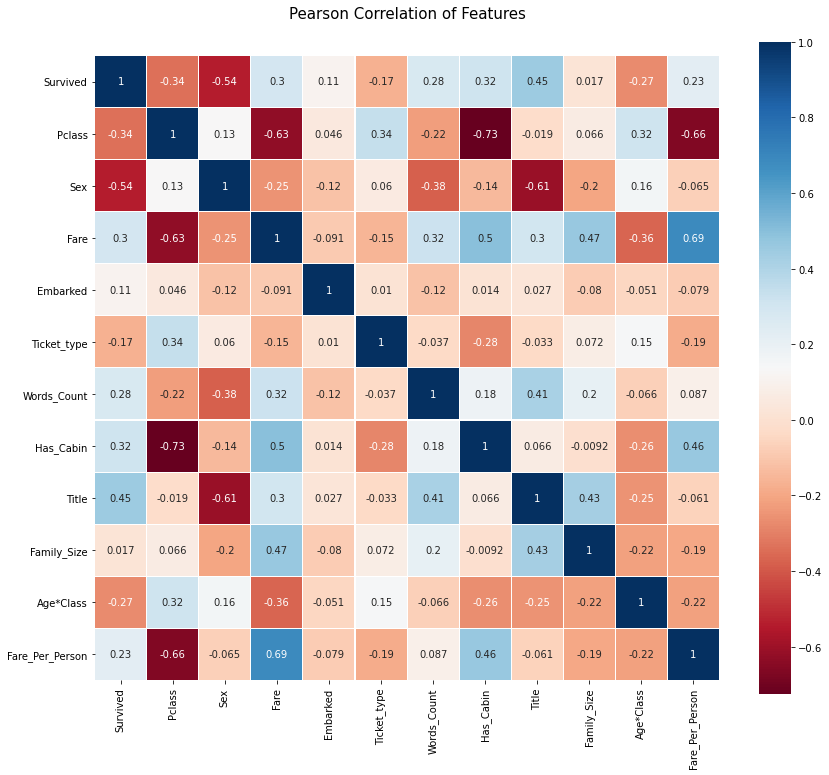

In [45]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [46]:
data_train = data_train.drop(['Fare_Per_Person' ], axis=1)

In [47]:
selection_model = RandomForestClassifier(random_state=3)
main_model = LogisticRegression(solver='liblinear', penalty='l1')
pipe_selection = make_pipeline(StandardScaler(), SelectFromModel(selection_model), main_model) 
data_test['Fare_Per_Person'] = data_test['Fare_Per_Person'].fillna(data_test['Fare_Per_Person'].median())
features = ['Pclass' ,'Sex',  'Fare' , 'Embarked' , 'Ticket_type' , 'Words_Count' , 'Has_Cabin' , 'Title'  ,'Family_Size' , 'Age*Class']
X = data_train[features]
y = data_train['Survived']
pipe_selection.fit(X, y)
pred = pipe_selection.predict(data_test[features])
pred
kaggle = data_test
kaggle = kaggle.drop(['Pclass' ,'Sex',  'Fare' , 'Embarked' , 'Ticket_type' , 'Words_Count' , 'Has_Cabin' , 'Title' ,
                      'Name','Age','SibSp','Parch' ,'Ticket' ,'Cabin' ,'Fare_Per_Person'
                      ,'Family_Size' , 'Age*Class'], axis=1)
kaggle['Survived'] = pred
kaggle

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,0
1307,0


In [48]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
kaggle.to_csv('out.zip', index=True,
    compression=compression_opts)  

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

My kaggle score 0.76315

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [49]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [50]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [51]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [52]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [54]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

ValueError: X has 57 features per sample; expecting 6

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

numerically, the AUC ROC is equal to the Wilcoxon-Mann-Whitney statistic: 
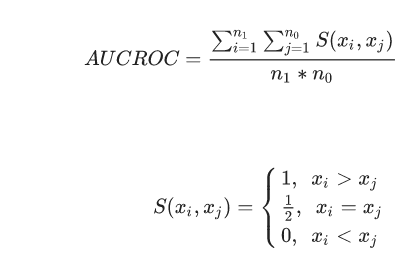



Let's set three distribution functions: 
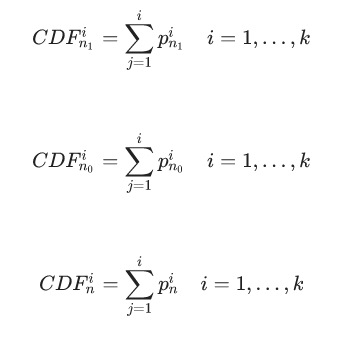


We write down Wilcoxon's formula in probabilistic form and transform it
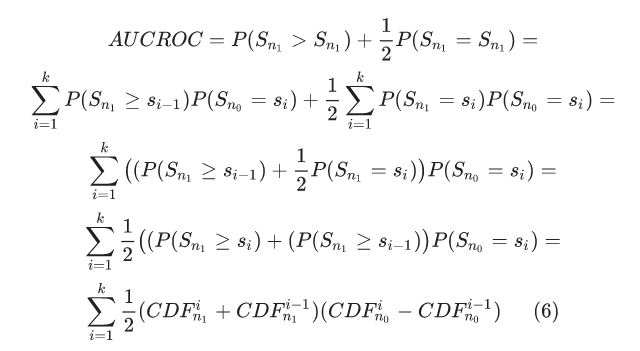



we can write the formula for the area under the Lift Curve 
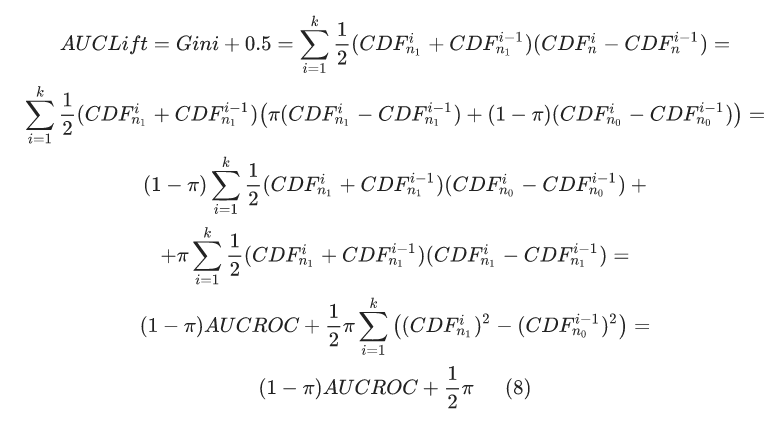

For an ideal model, the formula will be 
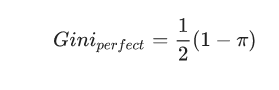


Therefore, we get: 

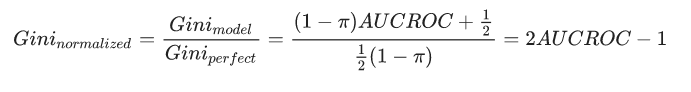

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

as well as the normalized gini coefficient, I think the area under the error curve is also fine, but since they are dependent from what was proved above, this does not make sense. it seems to me that the recall metric would be good, since it will take into account incorrect predictions 

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [55]:
num_0 = len(insurance_data[insurance_data['target']==0])

oversampled_data = pd.concat([ insurance_data[insurance_data['target']==0] ,
                              insurance_data[insurance_data['target']==1].sample(num_0, replace=True) ])
oversampled_data

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282624,1,0,2,0,0,0,1,0,0,0,...,7,1,5,9,0,0,0,0,0,0
1323179,1,5,1,4,0,4,0,1,0,0,...,6,3,4,10,0,0,1,0,0,1
45213,1,2,1,6,1,2,0,1,0,0,...,7,1,3,8,0,1,1,1,0,0


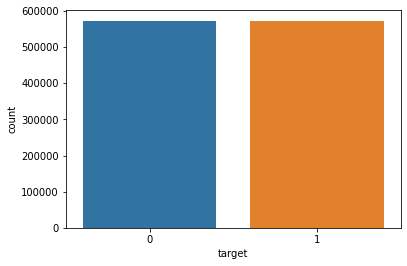

In [56]:
sns.countplot(x='target', data=oversampled_data)
plt.show()

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(oversampled_data[numeric_features].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


In [ ]:
oversampled_data = oversampled_data.drop(['ps_reg_03','ps_reg_02', 'ps_car_13' ], axis=1)

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



pipeline = Pipeline(steps=[('standardscaler', StandardScaler()),
                            ('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy"))]
                   )


In [ ]:
y = oversampled_data['target']
X = oversampled_data.drop(columns=['target'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline.fir(X,y)

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

# 🤷‍
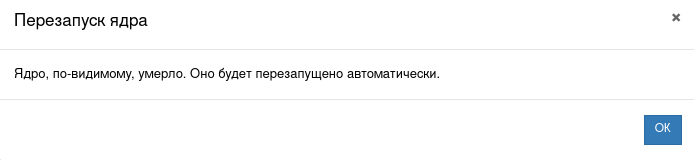